In [1]:
import numpy as np
from tasks.symbolic.embeddings import VectorEmbeddings
from examples import example_defaults

** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.


At any given point in time, the population responses $\mathbf{x}(t)=F(\mathbf{x}, \mathbf{u})$ contain information about current and past inputs, reverberating in the system states, as well as transformations performed on the input through the nonlinear projections. To assess the information content and the usefulness of such internal states to perform certain tasks, we first need strategies to adequately gather the population response vectors such that they directly relate to the input process, while avoiding memory overflow.  

------
Preliminary steps

**Note:** For simplicity, we will just use default task and network instanciations... 

* Initialize NEST kernel

In [2]:
resolution = 0.1
example_defaults.reset_kernel(resolution=resolution, np_seed=123456)

* Create target network (SNN) - here load a simple default SNN

In [3]:
snn, snn_recurrent_connections = example_defaults.default_network(record_spikes=True)

[__init__.py:47 - INFO] Initializing Brunel BRN architecture (NEST-simulated)
[__init__.py:97 - INFO] Creating populations:
[__init__.py:121 - INFO] - Population E, with ids [1-80]
[__init__.py:121 - INFO] - Population I, with ids [81-100]
[__init__.py:488 - INFO] Connecting Devices: 
[__init__.py:129 - INFO]   - Attaching spike_detector with gid [(101,)] to population E
[__init__.py:509 - INFO] - Connecting spike_detector to E, with label E_spike_detector and id (101,)
[__init__.py:129 - INFO]   - Attaching spike_detector with gid [(102,)] to population I
[__init__.py:509 - INFO] - Connecting spike_detector to I, with label I_spike_detector and id (102,)
[__init__.py:205 - INFO] Randomizing initial values:
[__init__.py:95 - INFO] - Randomizing V_m state in Population E
[__init__.py:95 - INFO] - Randomizing V_m state in Population I
[__init__.py:1008 - INFO] ========================================================
[__init__.py:1009 - INFO]  Brunel BRN architecture (NEST-simulated):
[__


Loading default neuron parameter - iaf_psc_delta, fixed voltage threshold, fixed absolute refractory time


* Create an input sequencer and sequence of length 10. 

In [4]:
sequencer, sequence = example_defaults.default_tasks(n_tokens=10, T=10)

[sequences.py:132 - INFO] Generating symbolic sequencer
[sequences.py:161 - INFO] Generating a random sequence of length 10, from a set of 10 symbols


* Create a [vector embedding](embeddings.ipynb#section3.1) (or any other) for this example

In [5]:
emb = VectorEmbeddings(vocabulary=sequencer.tokens).binary_codeword(dim=100, density=0.1)

[embeddings.py:28 - INFO] Creating symbolic embeddings
[embeddings.py:91 - INFO] - 10 symbols encoded as binary-codeword


* Generate discrete stimulus sequence and convert it to continuous input by unfolding the stimulus representations 
in time (see [unfolding embeddings](embeddings.ipynb#section4.1.2)), or, alternatively, convert each token to a unique 
spatiotemporal spike pattern (see [frozen noise embeddings](embeddings.ipynb#section4.1.1)):

In [6]:
discrete_stim_seq = emb.draw_stimulus_sequence(sequence, as_array=True)

signal_pars = {'duration': 50.,'amplitude': 250.,'kernel': ('box', {}),'dt': resolution}
signal = emb.unfold(to_signal=True, **signal_pars)

[embeddings.py:219 - INFO] Generating stimulus sequence: 10 symbols
[embeddings.py:28 - INFO] Creating symbolic embeddings
[embeddings.py:362 - INFO] Populating Stimulus Set: 
[embeddings.py:91 - INFO] - 10 symbols encoded as continuous signal unfolding


* Draw stimulus sequence:

In [7]:
stim_isi = 10.
stim_seq, stim_info = signal.draw_stimulus_sequence(sequence, onset_time=0.1, continuous=True, intervals=stim_isi)

[embeddings.py:655 - INFO] Generating stimulus sequence: 10 symbols
[embeddings.py:605 - INFO] Concatenating stimulus sequence


* Encode stimuli (see [encodings](encodings.ipynb#section6)):
    * Stimuli are provided in `batches` comprising sequences of length $T$.
    * SNNs are a special case, as the input needs to be delivered in specific forms and requires the use of NEST generator devices.

In [8]:
from encoders import NESTEncoder, InputMapper

In [9]:
gen = NESTEncoder('inhomogeneous_poisson_generator', stim_seq=stim_seq, label='poisson-input',
                              dim=emb.embedding_dimensions)
gen.add_parrots(dt=resolution)

[__init__.py:35 - INFO] Creating Generators: 
[__init__.py:38 - INFO] - poisson-input [(103,)-(202,)]
[__init__.py:45 - INFO] Creating input parrots for poisson-input:
[__init__.py:77 - INFO] - Population poisson-input-parrots, with ids [203-302]
[__init__.py:129 - INFO]   - Attaching spike_detector with gid [(303,)] to population input-parrots


* Connect encoders

In [10]:
# input synapses
input_syn = {'model': 'static_synapse', 'delay': 0.1, 'weight': 3.}
input_conn = {'rule': 'all_to_all'}

input_synapses = {
    'connect_populations': [('E', gen.name), ('I', gen.name),],
    'weight_matrix': [None, None],
    'conn_specs': [input_conn, input_conn],
    'syn_specs': [input_syn, input_syn]
}
input_to_snn_connections = InputMapper(source=gen, target=snn, parameters=input_synapses)

[__init__.py:116 - INFO] Connecting input generators: poisson-input -> Brunel BRN
[__init__.py:127 - INFO]     - ('E', 'poisson-input') [static_synapse]
[__init__.py:127 - INFO]     - ('I', 'poisson-input') [static_synapse]


----

# **11. State extraction and sampling - gathering population responses** <a id='section11'></a>

SNNs constitute a very special case, where not only the [encoding/stimulation](encodings.ipynb#section6.1) processes, but also the recording and state acquisition processes rely on `NEST` devices and thus present several unique challenges, particularly due to the non-zero delays introduced when connecting devices. To gather state samples at the correct times, we need to compensate for the delays. 

The `SpikingExtractor` class takes care of all these specificities. It is instantiated with a parameter dictionary containing all the desired sampling strategies, with the following structure:

```python
extractor_parameters = {
    'unique_label': {
        'population': ['E', 'I'],   # population or list of populations to record the activity from
        'variable': 'spikes',       # state variable - 'V_m' or 'spikes'
        'filter_time': 20.,         # exponential, low-pass filter time constant (if variable==spikes)
        'average_states': True,     # average activity within one stimulus, to obtain one unique state vector
        'sampling_rate': 100.,      # Hz - rate at which to sample the states
        'sampling_times': None,     # 
        'sample_isi': False         # if False, only sample during stimuli and discard samples from the isi
    },
}
```

## 11.1. Fixed and constant signal durations and ISIs

We start with the simplest case, where all stimuli have a fixed duration and ISI and so the responses can be sampled without additional corrections. 

In the following examples, the expected sampling times are illustrative and rely on `stim_onset = 0.1` and `encoding_delay = 0.1`, adjusted for any potential decoding delay. There are 10 stimuli, each with a duration of 50 ms followed by an inter-stimulus interval of 10 ms.

    
### 11.1.1. Sampling at a fixed rate

This sampling method relies on gathering samples of the population state at regular intervals, determined by the `sampling_rate` parameter. This procedure results in a single `StateMatrix`, containing all the samples. If `average_states=True`, the samples are averaged within each stimulus+isi window, resulting in a single, representative state vector per stimulus. If the stimulus duration and ISI are fixed, the rate-based sampling strategy requires that the length of the stimulus+isi be a multiple of the sampling rate so that the number of samples acquired for each stimulus (+isi) is constant. For variable duration and ISI length, see [this example](state_sampling_variable.ipynb). 
    

**Important note:** The sampled times corresponding to each stimulus are always relative to ~~stimulus onset.~~ to `0.`, and have an offset of `encoding_delay` relative to the stimulus onset `stim_onset`. For instance, in the case of a stimulus lasting 50 ms with an onset at 0.1 ms, simulation resolution 0.1 ms and sampling rate of 10kHz, the recorded times of the 500 samples lie in the closed interval `[0.2, 50.1]`. This ensures that the entire stimulus is "captured" in the activity recorded from the network. For more details and other scenarios, see the examples below.

The below specification will sample the activity at every 10 ms, resulting in state vectors representing averaged activity across the following windows: `mean([10.1, 20.1, ... 50.1])`, ... , `mean([540.1, 550.1, ... 590.1])`. There will be 10 samples recorded in total (len(sequence)).

In [11]:
extractor_parameters = {
    # state extractor label, must be unique
    'my_label_tau20_EI': {
        'population': ['E', 'I'],   # if list, extract from merged populations
        'variable': 'spikes',       # state variable
        'filter_time': 20.,         # time constant to filter the spiking activity with 
        'average_states': True,     # average activity within one stimulus. Sampling rate must be 
                                    # compatible with the stimulus length + isi. State matrix will be N x T
        'sampling_rate': 100.,      # Hz - one state matrix containing all the sampled time points
        'sample_isi': False         # if False, only sample during stimuli and discard samples from the isi
    },
}

The following example illustrates an **erroneous configuration**. Consider the current example where `stim_duration = 50` but `stim_isi = 6 # (ms)`. `stim_onset = 0.1` and `encoding_delay = 0.1` remain unchanged. The example below would then yield 5 samples (no samples can be recorded during the ISI) for the first stimulus running 0.1 - 56.0 ms, at `[10.1, ..., 50.1]`, and 6 samples for the second stimulus running between 56.1 - 112.0, at `[60.1, 70.1, ..., 110.1.]`. This is because the sampling rate is fixed and relative to the first stimulus onset. In this case, it records a sample at every 10 ms, irrespective of the onset times of the later stimuli.

In [12]:
# will be discarded
wrong_config = { 
    'label_can_be_anything': {
        'population': 'E',   
        'variable': 'spikes',       
        'filter_time': 20.,         
        'sampling_rate': 100.,      # this samples the timeline at 10 ms intervals
        'sample_isi': True          # sample during stimuli and ISI
    },
}

### 11.1.2. Sampling at stimulus offset

The most commonly used state acquisition strategy consists of gathering a single state vector $\mathbf{x}$, typically at stimulus offset. The following parameter configuration sample at fixed offsets relative to stimulus onset. Obviously, the `sample_isi` parameter does not have an effect here. For the running example (see above), the first stimulus ends at `50.0` ms (including), but as there can still be a last spike at exactly `50.0` ms which must be captured, we consider the offset to be at `50.1` ms.

In [13]:
extractor_parameters.update({
    'extractor_fixed_Vm_I': {
        'population': 'I',
        'variable': 'V_m',
        'average_states': False,  # always set to False when sampling at offset
        'sampling_times': ['stim_offset']
    }
})

    
Sample during isi (60 samples in total):


In [14]:
extractor_parameters.update({
    'extractor_isi_sampling': {
        'population': 'E',
        'variable': 'spikes',
        'filter_time': 15.,
        'sampling_rate': 100.,
        'sample_isi': True
    }
})

Some additional examples for plotting purposes...

In [15]:
extractor_parameters.update({
    'extractor_rate100_spikes_E': {
        'population': 'E',
        'variable': 'spikes',
        'filter_time': 15.,
        'sampling_rate': 100.,
    },
    'extractor_rate1000_spikes_E': {
        'population': 'E',
        'variable': 'spikes',
        'filter_time': 15.,
        'sampling_rate': 1000.,
    },
        'extractor_rate10000_spikes_E': {
        'population': 'E',
        'variable': 'spikes',
        'filter_time': 15.,        
        'sampling_rate': 10000.,
    },
    'extractor_rate10000_Vm_E': {
        'population': 'E',
        'variable': 'V_m',        
        'sampling_rate': 10000.,
    }
})

### 11.1.3. Creating and connecting state extractors 

The extractor parameters exemplified above can all be used (simultaneously or not) to acquire different samples of the population dynamics. To create and connect all extractor devices, we simply use the `connect_state_extractors` method of the `SpikingNetwork` object. 

**Note:** Both stimulating and recording devices introduce delays which need to be accounted and compensated for in order to acquire the relative responses at the correct times.

In [16]:
snn.connect_state_extractors(extractor_parameters, encoder=gen, input_mapper=input_to_snn_connections,
                             stim_duration=signal_pars['duration'], stim_isi=stim_isi, to_memory=True)

[extractors.py:487 - INFO] Connecting extractors (SpikingExtractor):
[extractors.py:494 - INFO] 	- State [my_label_tau20_EI] from populations ['E', 'I'] [spikes]
[extractors.py:306 - INFO] 	  - Extractor (rate sampling)
[extractors.py:307 - INFO] 		- offset = 10.299999999999999 ms (stimulus onset + total delay + sim_res step)
[extractors.py:308 - INFO] 		- interval = 10.0 ms
[extractors.py:527 - INFO] 		- total delays = 0.30000000000000004 ms (0.1 encoder + 0.2 extractor delay)
[extractors.py:528 - INFO] 		- NEST device id(s): [404]
[extractors.py:494 - INFO] 	- State [extractor_fixed_Vm_I] from populations I [V_m]
[extractors.py:306 - INFO] 	  - Extractor (offset sampling)
[extractors.py:307 - INFO] 		- offset = 50.2 ms (stimulus onset + total delay + sim_res step)
[extractors.py:308 - INFO] 		- interval = 60.0 ms
[extractors.py:527 - INFO] 		- total delays = 0.2 ms (0.1 encoder + 0.1 extractor delay)
[extractors.py:528 - INFO] 		- NEST device id(s): [405]
[extractors.py:494 - INFO] 	

### 11.1.4. Simulate and plot

Simulate and plot. We need to include the total delay (encoding, decoding) into simulation time for correct extraction.
Additionally, we need to simulate one resolution step as the multimeter's last sample is at `total_simulation_time - simulation_resolution`.

In [17]:
total_delay = input_to_snn_connections.total_delay + snn.state_extractor.max_extractor_delay
snn.simulate(stim_seq.t_stop + total_delay + resolution)

Extract activity to be decoded and create state matrices. Print extraction report.

In [18]:
snn.state_extractor.extract_global_states(stim_info)
snn.extract_population_activity()  # this is only needed to plot the spikes

[extractors.py:803 - INFO] Extracting and storing recorded activity from state extractor my_label_tau20_EI
[extractors.py:835 - INFO]   - Reading extractor 404 [spikes] with rate sampling at 
[extractors.py:582 - INFO]   - Flushing devices of state extractor my_label_tau20_EI [404] from populations spikes
[extractors.py:803 - INFO] Extracting and storing recorded activity from state extractor extractor_fixed_Vm_I
[extractors.py:840 - INFO]   - Reading extractor 405 [V_m] at sampling offset
[extractors.py:582 - INFO]   - Flushing devices of state extractor extractor_fixed_Vm_I [405] from populations V_m
[extractors.py:803 - INFO] Extracting and storing recorded activity from state extractor extractor_isi_sampling
[extractors.py:835 - INFO]   - Reading extractor 486 [spikes] with rate sampling at 
[extractors.py:582 - INFO]   - Flushing devices of state extractor extractor_isi_sampling [486] from populations spikes
[extractors.py:803 - INFO] Extracting and storing recorded activity from 

In [19]:
snn.state_extractor.report()

[extractors.py:903 - INFO] 
[extractors.py:904 - INFO] ==========================
[extractors.py:905 - INFO] SNN StateExtractor summary
[extractors.py:907 - INFO] ---------------
[extractors.py:909 - INFO] State extractor [my_label_tau20_EI] from population(s) EI with gid(s) [404]
[extractors.py:914 - INFO]   - gathered 10 samples via rate-based sampling from spikes, extractor delay 0.2 ms
[extractors.py:918 - INFO]     - samples averaged across stimulus duration only, not ISI
[extractors.py:919 - INFO]     - note: only the last sampled timepoint from the averaged window is shown
[extractors.py:920 - INFO]     - network time (incl. encoder delay):
[extractors.py:921 - INFO]       [50.1, 110.1, 170.10000000000002] ... [590.1]
[extractors.py:922 - INFO]     - NEST kernel time (incl. all delays):
[extractors.py:924 - INFO]       [ 50.3 110.3 170.3] ... [590.3000000000001]
[extractors.py:907 - INFO] ---------------
[extractors.py:909 - INFO] State extractor [extractor_fixed_Vm_I] from popu

Plot some spiking activity and extracted states

[extractors.py:952 - INFO] ===========================
[extractors.py:953 - INFO] Example extractor activity: [extractor_rate100_spikes_E]


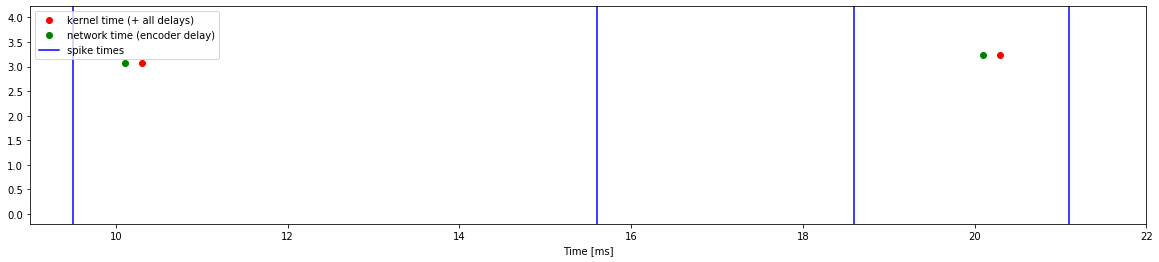

In [20]:
# just re-run the cells below by changing the id between (1-100)
neuron_id_to_plot = 12
snn.state_extractor.plot_samples('extractor_rate100_spikes_E', neuron_id=neuron_id_to_plot, start_t=10., stop_t=21.)


[extractors.py:952 - INFO] ===========================
[extractors.py:953 - INFO] Example extractor activity: [extractor_rate1000_spikes_E]


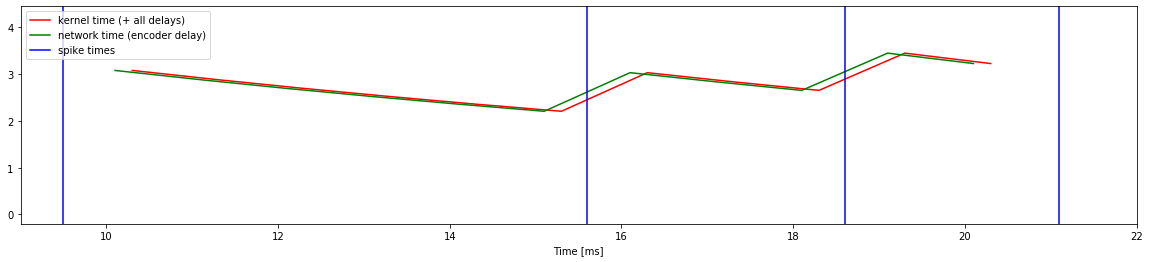

In [21]:
snn.state_extractor.plot_samples('extractor_rate1000_spikes_E', neuron_id=neuron_id_to_plot, marker='-',
                                 start_t=10., stop_t=21.)

[extractors.py:952 - INFO] ===========================
[extractors.py:953 - INFO] Example extractor activity: [extractor_rate10000_spikes_E]


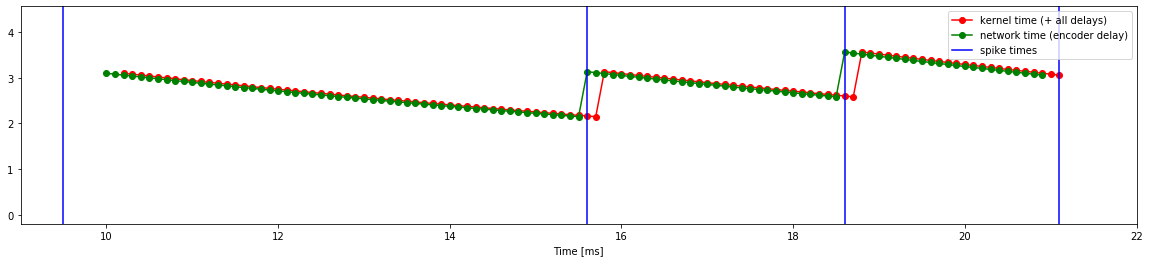

In [40]:
snn.state_extractor.plot_samples('extractor_rate10000_spikes_E', neuron_id=neuron_id_to_plot, marker='o-',
                                start_t=10., stop_t=21.)

### 11.1.5. Consistency checks
Ensure the sampled values are consistent across the different extractors
the sampling rate difference is a factor of 10. Pick a neuron and a sample for which to compare the values.

In [23]:
compare_neuron = 5
compare_sample = 0  # pick a sample index for comparison in the extractor with lower resolution

activity_lower_res = snn.state_extractor.pop_extractors['extractor_rate100_spikes_E'].activity[0][compare_neuron]
activity_higher_res = snn.state_extractor.pop_extractors['extractor_rate1000_spikes_E'].activity[0][compare_neuron]
assert np.isclose(activity_lower_res[compare_sample],
                  activity_higher_res[(compare_sample + 1) * 10 - 1]), "Error"

activity_lower_res = snn.state_extractor.pop_extractors['extractor_rate1000_spikes_E'].activity[0][compare_neuron]
activity_higher_res = snn.state_extractor.pop_extractors['extractor_rate10000_spikes_E'].activity[0][compare_neuron]
assert np.isclose(activity_lower_res[compare_sample],
                  activity_higher_res[(compare_sample + 1) * 10 - 1]), "Error"

### 11.1.6. Resulting state matrices

After extracting the network activity and global state, these must be compiled into state matrices that can be later used for learning and performing a task. `compile_state_matrices()` is a function of the network's state extractor object:

In [24]:
snn.state_extractor.compile_state_matrices('state_sampling_example_label')

[extractors.py:882 - INFO] Compiling state matrices...


The above function creates a `StateMatrix` object, standardized across all network models, for each state extractor label. The objects are stored within the corresponding `Population` objects, which can be accessed directly or through an interface function:

In [25]:
state_matrix = snn.find_population('E').state_matrices['extractor_isi_sampling']

# or, better (it does the same under the hood, with some error checks)
state_matrix = snn.find_state_matrix('E', 'extractor_isi_sampling')

The actual matrices can be accessed as follows (depending on the sampling method):

In [26]:
# each matrix contains 10 samples, and is of size N x Samples
state_matrix.matrix.shape


(80, 60)

----

## 11.2. Variable signal durations and ISIs

This condition introduces additional complications to the sampling process. To exemplify, we will start by re-defining the input signal properties and demonstrate different sampling strategies we can adopt in this scenario.

In [27]:
example_defaults.reset_kernel(resolution=resolution)

* Define a (uniform) distribution for the inter-stimulus interval and draw continuous stimulus sequence:

In [28]:
stim_interval = {'dist': np.random.uniform, 'params': {'low':1.0, 'high':10.0}}
stim_onset_time = 0.1

stim_seq, stim_info = signal.draw_stimulus_sequence(sequence, onset_time=stim_onset_time, 
                                                    continuous=True, intervals=stim_interval)

[embeddings.py:655 - INFO] Generating stimulus sequence: 10 symbols
[embeddings.py:605 - INFO] Concatenating stimulus sequence


* Create encoders

In [29]:
# inhomogeneous Poisson generator
gen = NESTEncoder('inhomogeneous_poisson_generator', stim_seq=stim_seq, label='poisson-input',
                              dim=emb.embedding_dimensions)

[__init__.py:35 - INFO] Creating Generators: 
[__init__.py:38 - INFO] - poisson-input [(1,)-(100,)]


* Re-create target network

In [30]:
# target network
snn_variable, snn_recurrent_connections = example_defaults.default_network(record_spikes=True)

[__init__.py:47 - INFO] Initializing Brunel BRN architecture (NEST-simulated)
[__init__.py:97 - INFO] Creating populations:
[__init__.py:121 - INFO] - Population E, with ids [101-180]
[__init__.py:121 - INFO] - Population I, with ids [181-200]
[__init__.py:488 - INFO] Connecting Devices: 
[__init__.py:129 - INFO]   - Attaching spike_detector with gid [(201,)] to population E
[__init__.py:509 - INFO] - Connecting spike_detector to E, with label E_spike_detector and id (201,)
[__init__.py:129 - INFO]   - Attaching spike_detector with gid [(202,)] to population I
[__init__.py:509 - INFO] - Connecting spike_detector to I, with label I_spike_detector and id (202,)
[__init__.py:205 - INFO] Randomizing initial values:
[__init__.py:95 - INFO] - Randomizing V_m state in Population E
[__init__.py:95 - INFO] - Randomizing V_m state in Population I
[__init__.py:1008 - INFO] ========================================================
[__init__.py:1009 - INFO]  Brunel BRN architecture (NEST-simulated):


Loading default neuron parameter - iaf_psc_delta, fixed voltage threshold, fixed absolute refractory time


* Connect encoders

In [31]:
# input synapses
input_syn = {'model': 'static_synapse', 'delay': 0.1, 'weight': 3.}
input_conn = {'rule': 'all_to_all'}

input_synapses = {
    'connect_populations': [('E', gen.name), ('I', gen.name),],
    'weight_matrix': [None, None],
    'conn_specs': [input_conn, input_conn],
    'syn_specs': [input_syn, input_syn]
}
input_to_snn_connections = InputMapper(source=gen, target=snn_variable, parameters=input_synapses)

[__init__.py:116 - INFO] Connecting input generators: poisson-input -> Brunel BRN
[__init__.py:127 - INFO]     - ('E', 'poisson-input') [static_synapse]
[__init__.py:127 - INFO]     - ('I', 'poisson-input') [static_synapse]


### 11.2.1. Sampling at a fixed rate
 
Sample the network activity at regular intervals, creating a single state matrix. If `average_states=True`, the samples are averaged within each stimulus+isi window. For variable stimulus / isi lengths, ...?    

In [32]:
extractor_parameters = {}

extractor_parameters.update({
    # state extractor label, must be unique
    'ex_E_rate10kHz_avg': {
        'population': 'E',   # if list, extract from merged populations
        'variable': 'spikes',       # state variable
        'filter_time': 15.,         # time constant to filter the spiking activity with 
        'average_states': True,     # average activity within one stimulus. Sampling rate must be 
                                    # compatible with the stimulus length + isi. State matrix will be N x T
        'sampling_rate': 10000.,    # Hz - one state matrix containing all the sampled time points
        'sample_isi': False         # if False, only sample during stimuli and discard samples from the isi
    },
})

* Whether to sample during ISI or not (to compare plots later)

In [33]:
extractor_parameters.update({
    'ex_E_isi_sampling': {
        'population': 'E',
        'variable': 'spikes',
        'filter_time': 15.,
        'sampling_rate': 10000.,
        'sample_isi': True
    },
    'ex_E_no_isi': {
        'population': 'E',
        'variable': 'spikes',
        'filter_time': 15.,
        'sampling_rate': 10000.,
        'sample_isi': False
    }
})

* For illustration purposes, sample membrane potential continuously

In [34]:
extractor_parameters.update({
    'ex_I_Vm_isi_sampling': {
        'population': 'I',
        'variable': 'V_m',
        'sampling_rate': 10000.,
        'sample_isi': True
    }
})

The following example illustrates an **erroneous configuration**. If the resolution of the input signal (stimulus
duration and ISI length) is 0.1 ms, the sampling rate must be at least 10kHz ~ 0.1 ms or higher. 

In [35]:
wrong_config = { 
    'resolution_too_low': {
        'population': 'E',   
        'variable': 'spikes',       
        'filter_time': 20.,         
        'sampling_rate': 100.,      # this samples the timeline at 10 ms intervals, which is not enough
        'sample_isi': True          # sample during stimuli and discard samples from the isi
    },
}

### 11.2.2. Sampling at fixed timepoints

Sample at fixed offsets relative to stimulus onset. This creates an individual state matrix for each specified sampling time. `sample_isi` and `average_states` don't have an effect here, whether there are samples collected during isi depends on the specified `sampling_times`. 
 
To sample at stimulus offset, add `'stim_offset'` to the `'sampling_times'` parameter.

In [36]:
extractor_parameters.update({
    'extractor_fixed_Vm_I': {
        'population': 'I',
        'variable': 'V_m',
        'average_states': False,                    # can't be True for fixed sampling
        'sampling_times': [1., 5., 'stim_offset']   # each offset creates a separate state matrix, 
                                                    # sample relative to stim. onset
    }
})

### 11.2.3. Creating and connecting state extractors

For signals with variable duration/ISI the, the state extractors connection routine must be called 
with `variable_signal=True`:   

In [37]:
input_to_snn_connections.determine_total_delay()  # this should probably be called automatically somewhere
snn_variable.connect_state_extractors(extractor_parameters, encoder=gen, input_mapper=input_to_snn_connections,
                             variable_signal=True, to_memory=True)

[extractors.py:487 - INFO] Connecting extractors (SpikingExtractor):
[extractors.py:494 - INFO] 	- State [ex_E_rate10kHz_avg] from populations E [spikes]
[extractors.py:306 - INFO] 	  - Extractor (variable rate sampling)
[extractors.py:307 - INFO] 		- offset = 0.4 ms (stimulus onset + total delay + sim_res step)
[extractors.py:308 - INFO] 		- interval = 0.1 ms
[extractors.py:527 - INFO] 		- total delays = 0.30000000000000004 ms (0.1 encoder + 0.2 extractor delay)
[extractors.py:528 - INFO] 		- NEST device id(s): [283]
[extractors.py:494 - INFO] 	- State [ex_E_isi_sampling] from populations E [spikes]
[extractors.py:306 - INFO] 	  - Extractor (variable rate sampling)
[extractors.py:307 - INFO] 		- offset = 0.4 ms (stimulus onset + total delay + sim_res step)
[extractors.py:308 - INFO] 		- interval = 0.1 ms
[extractors.py:527 - INFO] 		- total delays = 0.30000000000000004 ms (0.1 encoder + 0.2 extractor delay)
[extractors.py:528 - INFO] 		- NEST device id(s): [364]
[extractors.py:494 - I

### 11.2.3. Simulate and plot

In [38]:
total_delay = input_to_snn_connections.total_delay + snn.state_extractor.max_extractor_delay
snn_variable.simulate(stim_seq.t_stop + total_delay + resolution)

* Extract activity to be decoded and create state matrices. Print extraction report.

In [39]:
snn.state_extractor.extract_global_states(stim_info)
snn.extract_population_activity()  # this is only needed to plot the spikes

[extractors.py:803 - INFO] Extracting and storing recorded activity from state extractor my_label_tau20_EI


KeyError: 'to_memory'

In [ ]:
snn_variable.state_extractor.report()    

Plot some spiking activity and extracted states

In [ ]:
# just re-run the cells below by changing the id between (101-180)
neuron = 125
# snn.state_extractor.plot_samples('ex_E_isi_sampling', n_samples=100, neuron_id=neuron_id_to_plot, stim_info=stim_info)
snn_variable.state_extractor.plot_samples('ex_E_isi_sampling', neuron_id=neuron, stim_info=stim_info, 
                                 start_t=40., stop_t=50., marker='-')
snn_variable.state_extractor.plot_samples('ex_E_no_isi', neuron_id=neuron, stim_info=stim_info, 
                                 start_t=40., stop_t=50.)


Plot the continuously sampled membrane potential, including samples recorded during ISI. Note that the recordings begin at `stim_onset + encoding_delay` (green line, network time) and not at `0.`

In [ ]:
neuron = 185
snn.state_extractor.plot_samples('ex_I_Vm_isi_sampling', neuron_id=neuron, 
                                 stim_info=stim_info, start_t=0., stop_t=10., marker='-')


### 11.2.6. Resulting state matrices

After extracting the network activity and global state, these must be compiled into state matrices that can be later used for learning and performing a task. `compile_state_matrices()` is a function of the network's state extractor object:

In [ ]:
snn.state_extractor.compile_state_matrices('variable_delay_sm')